## Data Description

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

## Data Dictionary

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| instant|	record index |
| dteday|	date|
| season|	season (1:winter, 2:spring, 3:summer, 4:fall) |
| yr|	year (0: 2011, 1:2012) |
| mnth|	month ( 1 to 12)|
| hr|	hour (0 to 23)|
| holiday|	weather day is holiday or not |
| weekday|	day of the week|
| workingday|if day is neither weekend nor holiday is 1, otherwise is 0	|
| weathersit|1: Clear, 2: Mist, 3: Light Snow, 4: Heavy Rain 	|
| temp|	Normalized temperature in Celsius|
| atemp|Normalized feeling temperature in Celsius	|
| hum|	Normalized humidity|
| windspeed|Normalized wind speed	|
| casual|	count of casual users|
| registered|count of registered users	|
| cnt|	count of total rental bikes including both casual and registered |

## Objective

This project is to find out which time series model is suitable to predict bicycle demand in future.

## Steps taken for data cleaning or feature engineering

1. Load and perform simple data exploration
2. Drop unwanted features and convert to datetime index dataset
3. Perform time series visualization to look for trends and seasonality
4. Perform stationarity tests
5. Convert to stationary time series
6. Plot ACF and PACF to determine lags for models
7. Create train and test split
8. Create models and evaluate which are best

## Insight and key findings

We have used several time series models and found that RMSE figure is still high in the values of 4 digits.
We decided to use Auto-ARIMA method to determine which model is the best that is SARIMAX(1, 0, 0)x(3, 0, [1], 12).

## Next steps

We need to check more on the residuals and seasonality which may be useful for us to tweak the model. We may need to get more data for years 2013-2019 to see the trends and decompose them for analysis. Another model which was not tried is SARIMAX which requires extra features not found in this dataset. New collection of data will be required.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import math
import pmdarima as pm

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import lag_plot,autocorrelation_plot
#from pylab import rcParams

from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg,ARResults
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


In [2]:
df = pd.read_csv("Bike Rental UCI dataset.csv",parse_dates=['dteday'])

In [3]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [5]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Drop unwanted features / Simplifying the Dataset

In [6]:
df.drop(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday','weathersit','temp', 'atemp', 'hum', 'windspeed',
        'casual', 'registered'],axis=1,inplace=True)

In [7]:
df.head()

,dteday,cnt
0,2011-01-01,16
1,2011-01-01,40
2,2011-01-01,32
3,2011-01-01,13
4,2011-01-01,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dteday  17379 non-null  datetime64[ns]
 1   cnt     17379 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 271.7 KB


In [9]:
df2 = df.groupby('dteday').sum()
df2

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
...,...
2012-12-27,2114
2012-12-28,3095
2012-12-29,1341


In [10]:
df2.reset_index(inplace=True)

In [11]:
df2

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [12]:
df2.shape

(731, 2)

In [13]:
#df2.to_csv("bikeseries.csv",index=False)

## Time-Series Visualization

In [14]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col="dteday")

In [15]:
df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [16]:
df.index.freq = "D"

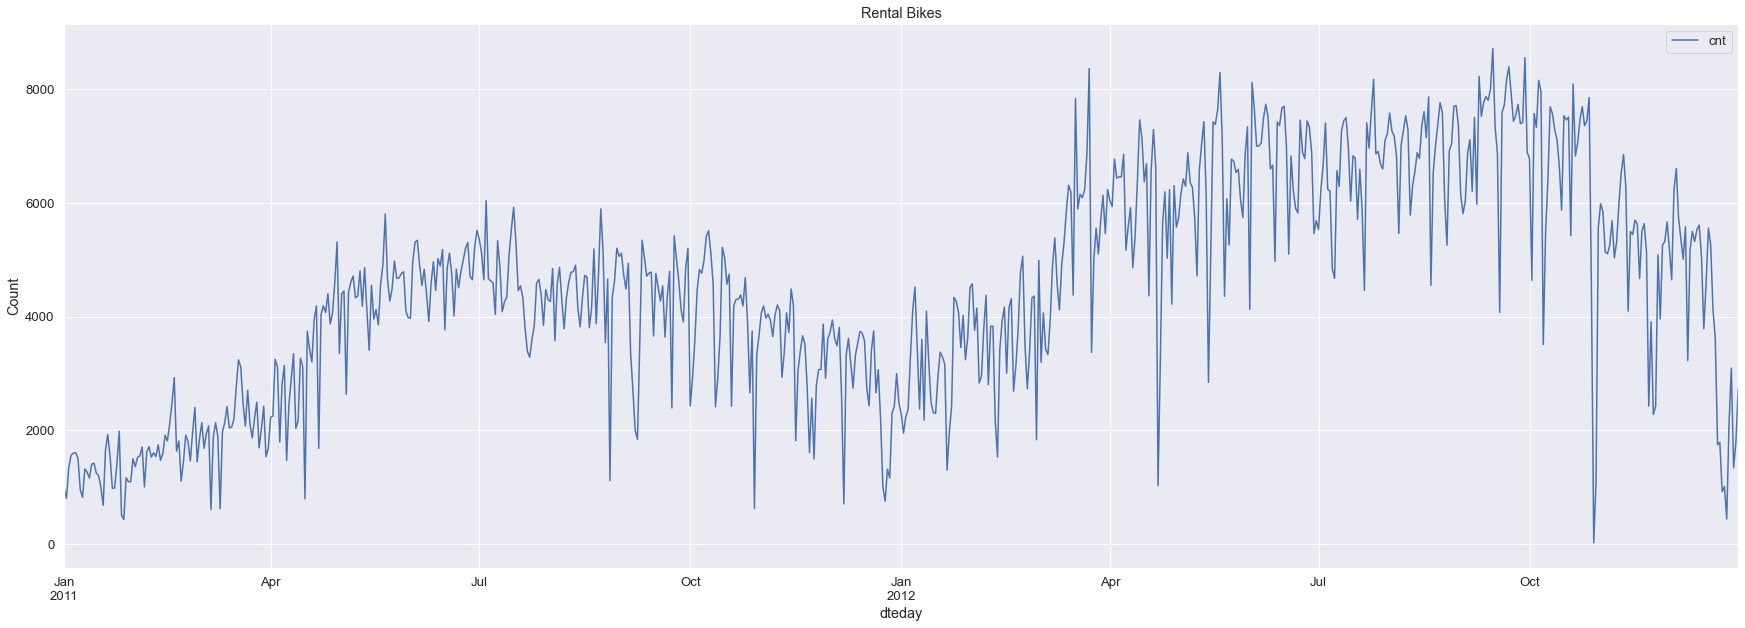

In [17]:
df.plot(figsize=(30,10), title="Rental Bikes")
plt.ylabel("Count")
plt.show()

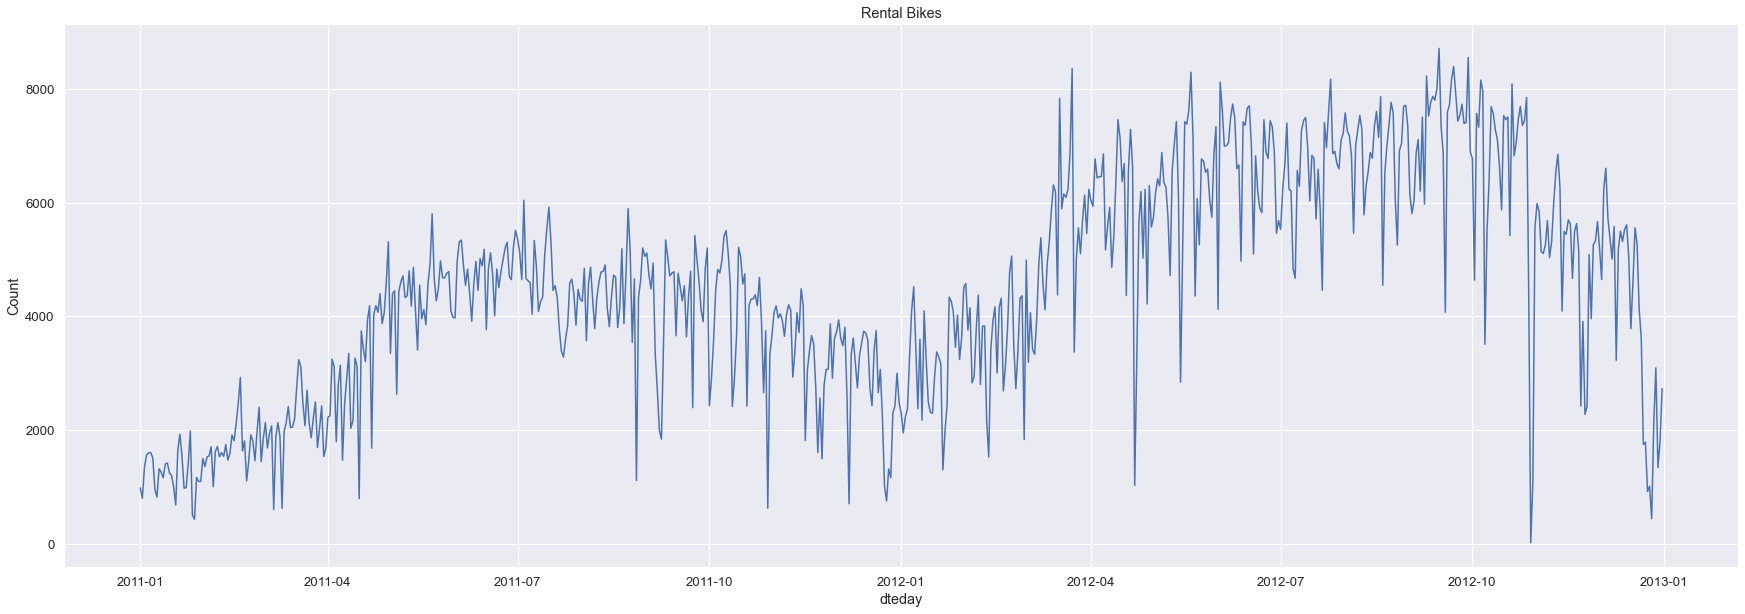

In [18]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=df.index,y=df.cnt,data=df, estimator=None)
#plt.xticks(rotation=90)
plt.title("Rental Bikes")
plt.ylabel("Count")
plt.show()

### Zooming in date range

In [19]:
zoomjan = df[(df.index >= '2011-01-01') & (df.index <= '2011-01-31')]

In [20]:
zoomjan

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
2011-01-06,1606
2011-01-07,1510
2011-01-08,959
2011-01-09,822


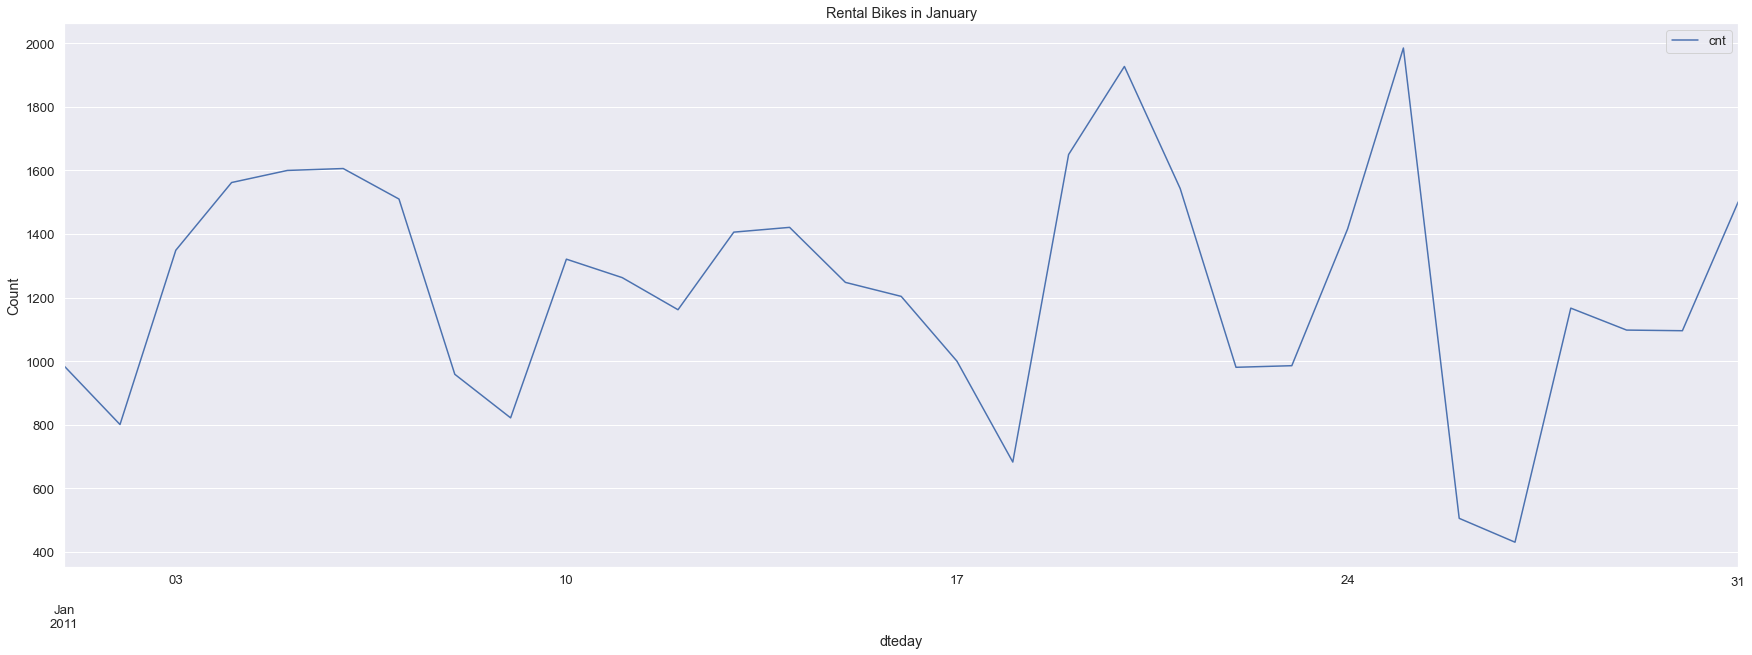

In [21]:
zoomjan.plot(figsize=(30,10), title="Rental Bikes in January")
plt.ylabel("Count")
plt.show()

### Trendline

In [22]:
df.reset_index(inplace=True)

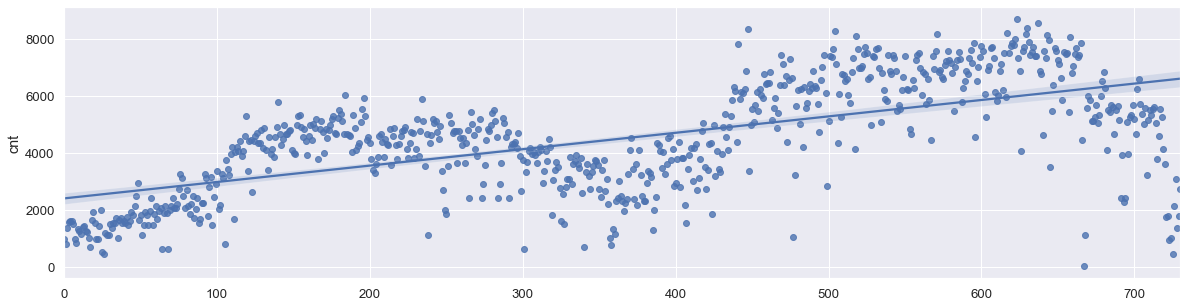

In [23]:
plt.figure(figsize=(20,5))
sns.regplot(x=df.index.values, y=df.cnt, data=df)
plt.show()

### Autocorrelation Plot

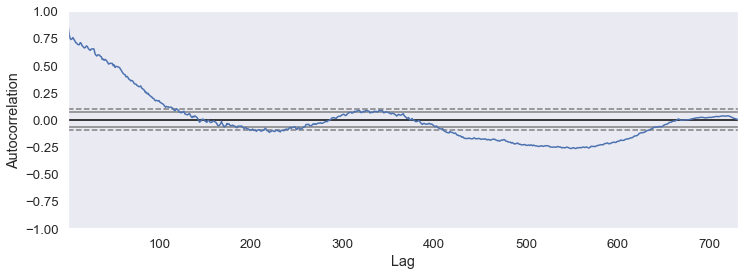

In [24]:
plt.figure(figsize=(12,4))
autocorrelation_plot(df['cnt'])
plt.show()

## Decomposing Time Series

### Additive or Multiplication model

In [25]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col="dteday")

In [26]:
df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [27]:
df.index.freq = "D"

In [28]:
result = seasonal_decompose(x=df['cnt'], model='additive')

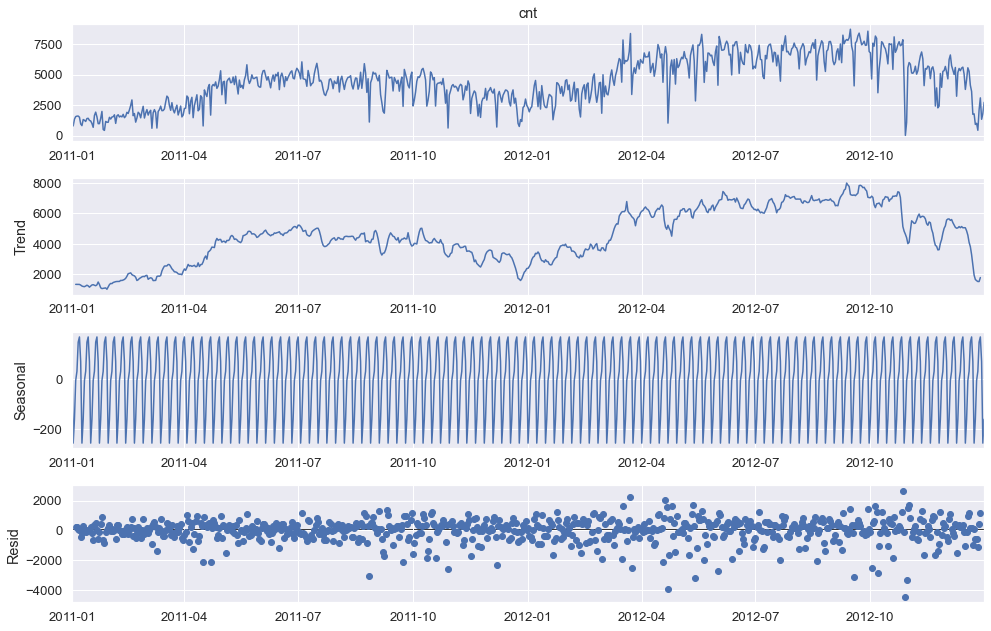

In [29]:
#plt.title("Additive Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result.plot()
plt.show()

In [30]:
result2 = seasonal_decompose(x=df['cnt'], model='multiplicative')

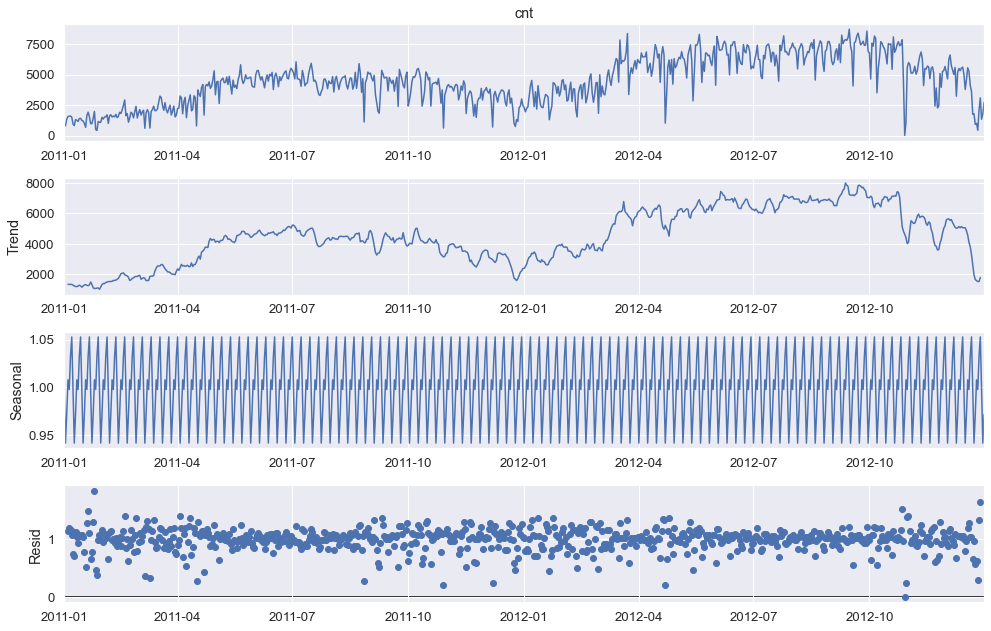

In [31]:
#plt.title("Multiplicative Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result2.plot()
plt.show()

## Stationarity Tests

In [32]:
adfuller(df.cnt)

(-1.8774481444374302,
 0.3427434403392191,
 13,
 717,
 {'1%': -3.439503230053971,
  '5%': -2.8655794463678346,
  '10%': -2.5689210707289982},
 11740.390931163352)

In [33]:
dftest = adfuller(df['cnt'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
dfout

ADF Test Statistic      -1.877448
p-value                  0.342743
# Lags Used             13.000000
# Observations         717.000000
critical value(1%)      -3.439503
critical value(5%)      -2.865579
critical value(10%)     -2.568921
dtype: float64

Result: Fail to reject null hypothesis and data is non-stationary

## Make the time series data stationary

### Differencing Method

In [34]:
df = pd.read_csv("bikeseries.csv", parse_dates=['dteday'], index_col="dteday")

In [35]:
df.head()

,cnt
dteday,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


In [36]:
df.index.freq = "D"

In [37]:
result_a = seasonal_decompose(x=df['cnt'], model='additive')

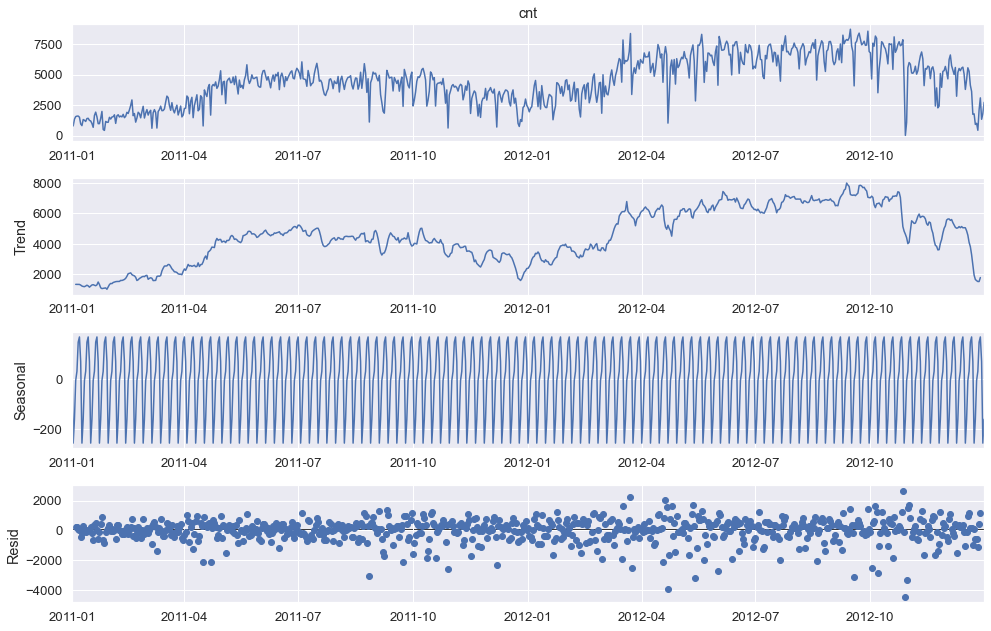

In [38]:
#plt.title("Additive Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result_a.plot()
plt.show()

In [39]:
df["lag1"] = df['cnt'].shift(1)

In [40]:
df["diff_1"] = df['cnt'].diff(periods=1) #Differencing by one period

In [41]:
df.head()

,cnt,lag1,diff_1
dteday,,,
2011-01-01,985,NaN,NaN
2011-01-02,801,985.0,-184.0
2011-01-03,1349,801.0,548.0
2011-01-04,1562,1349.0,213.0
2011-01-05,1600,1562.0,38.0


In [42]:
result_b = seasonal_decompose(x=df.iloc[1:,2], model='additive')

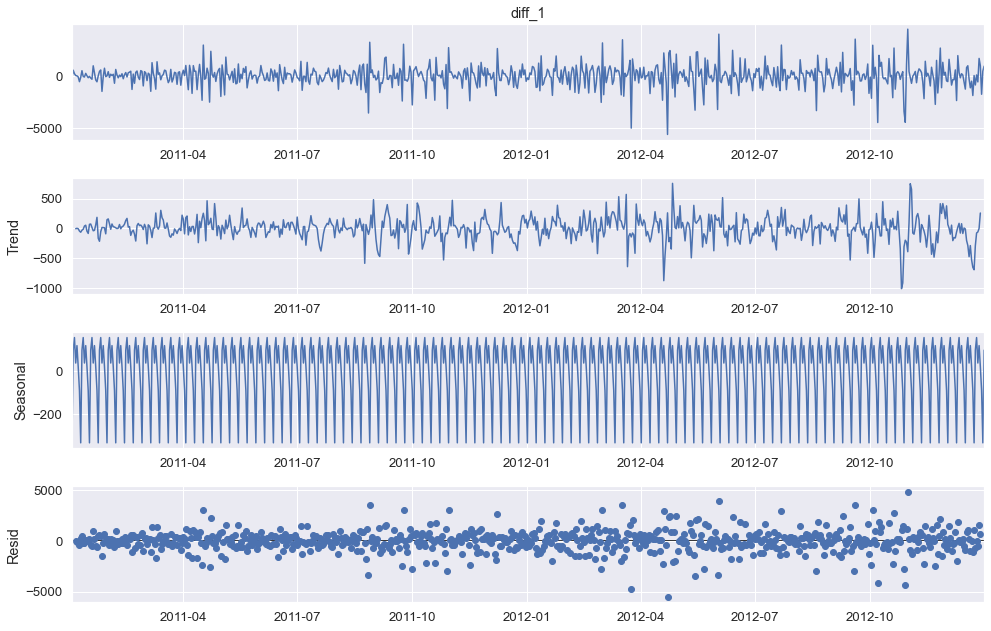

In [43]:
#plt.title("Additive Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result_b.plot()
plt.show()

The Trend Graph Line has constant mean and standard deviation.

In [44]:
#Remove seasonality
df["diff_12"] = df['diff_1'].diff(periods=12)

In [45]:
df.head(20)

,cnt,lag1,diff_1,diff_12
dteday,,,,
2011-01-01,985,NaN,NaN,NaN
2011-01-02,801,985.0,-184.0,NaN
2011-01-03,1349,801.0,548.0,NaN
2011-01-04,1562,1349.0,213.0,NaN
2011-01-05,1600,1562.0,38.0,NaN
2011-01-06,1606,1600.0,6.0,NaN
2011-01-07,1510,1606.0,-96.0,NaN
2011-01-08,959,1510.0,-551.0,NaN
2011-01-09,822,959.0,-137.0,NaN


In [46]:
result_c = seasonal_decompose(x=df.iloc[13:,3], model='additive')

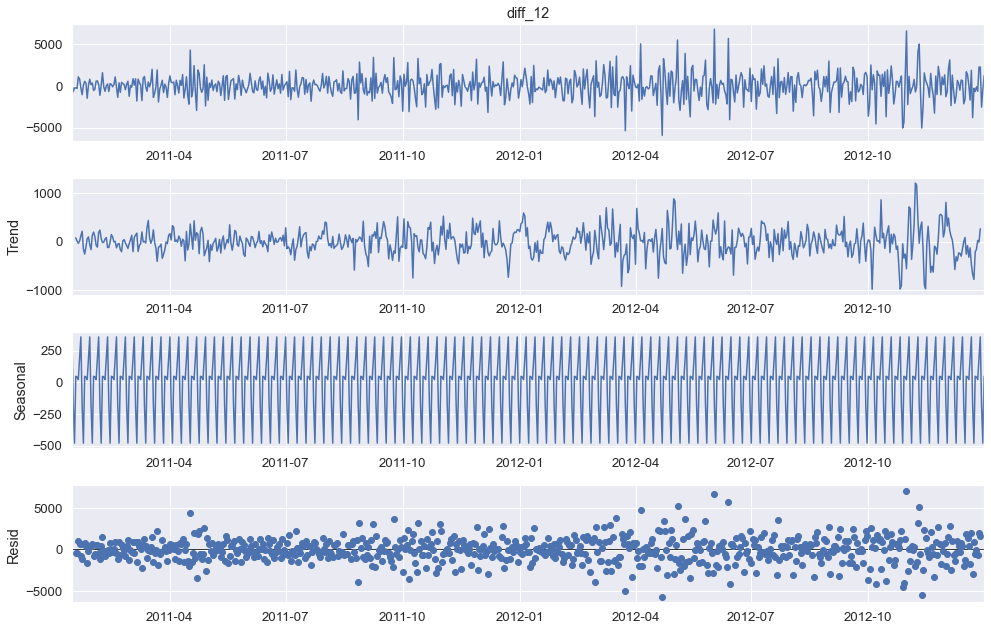

In [47]:
#plt.title("Additive Decomposition")
plt.rcParams['figure.figsize'] = (14,9)
result_c.plot()
plt.show()

The difference 12 periods removed the seasonality.

In [48]:
#Save as csv
#df.to_csv('cleaned.csv',index=True)

In [49]:
adfuller(df["diff_12"].dropna())

(-12.469680939692507,
 3.265878176517687e-23,
 18,
 699,
 {'1%': -3.439739809554328,
  '5%': -2.86568368980381,
  '10%': -2.5689766074363334},
 11813.874516833725)

In [50]:
print("ADF Test for Seasonal First Difference")

dftest = adfuller(df["diff_12"].dropna())
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})'] = val
    
dfout

ADF Test for Seasonal First Difference


ADF Test Statistic    -1.246968e+01
p-value                3.265878e-23
# Lags Used            1.800000e+01
# Observations         6.990000e+02
critical value(1%)    -3.439740e+00
critical value(5%)    -2.865684e+00
critical value(10%)   -2.568977e+00
dtype: float64

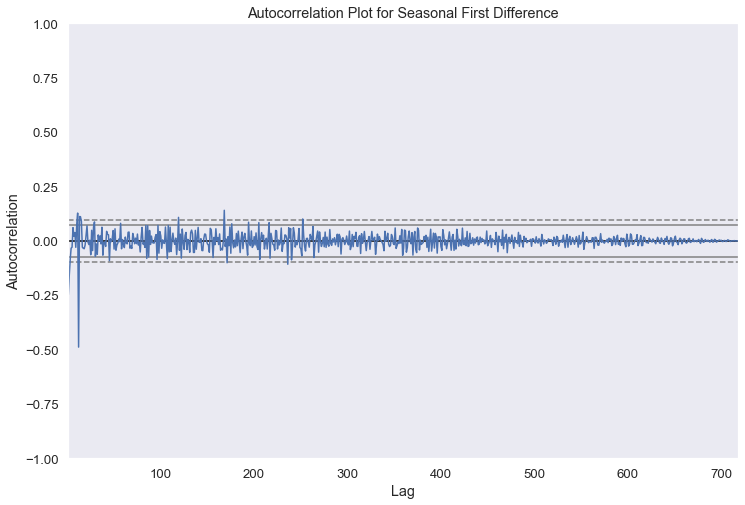

In [51]:
plt.rcParams['figure.figsize'] = (12,8)
autocorrelation_plot(df["diff_12"].dropna())
plt.title("Autocorrelation Plot for Seasonal First Difference")
plt.show()

## ACF (Autocorrelation Function)

<Figure size 1440x576 with 0 Axes>

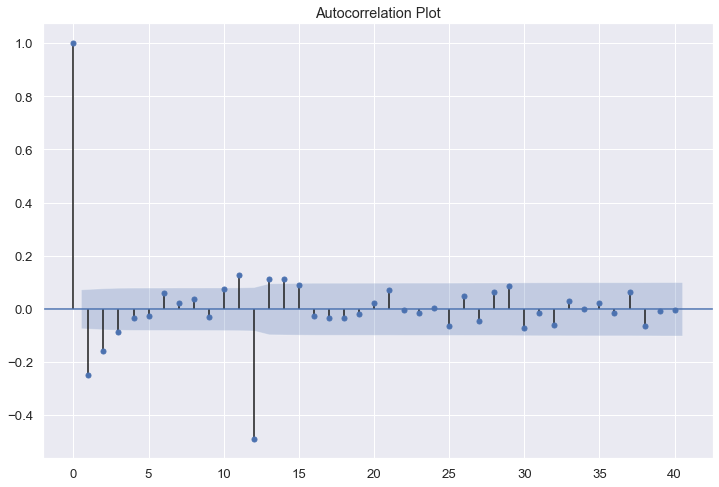

In [52]:
plt.figure(figsize=(20,8))
sgt.plot_acf(df["diff_12"].dropna(), lags=40)
plt.title("Autocorrelation Plot")
plt.show()

Looking at the ACF plot, we only see a significant peaks at lag 1,2,3,12 suggesting a non-seasonal MA(1,2,3,12) processes.

## PACF (Partial Autocorrelation Function)

<Figure size 1008x576 with 0 Axes>

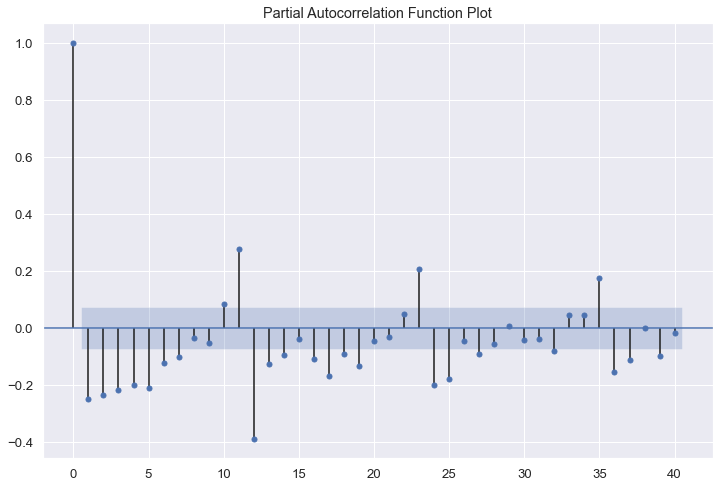

In [53]:
plt.figure(figsize=(14,8))
sgt.plot_pacf(df["diff_12"].dropna(), lags=40, method='ols')
plt.title("Partial Autocorrelation Function Plot")
plt.show()

We can see from the PACF that we have a significant peak at lag 7, which suggest an AR(7) process. Also, we have another peak at lag 12, suggesting a seasonal autoregressive process of order 1 (P = 1)

## Remove unwanted columns

In [54]:
df.head()

,cnt,lag1,diff_1,diff_12
dteday,,,,
2011-01-01,985,NaN,NaN,NaN
2011-01-02,801,985.0,-184.0,NaN
2011-01-03,1349,801.0,548.0,NaN
2011-01-04,1562,1349.0,213.0,NaN
2011-01-05,1600,1562.0,38.0,NaN


In [55]:
del df["cnt"]

In [56]:
del df["lag1"]

In [57]:
del df["diff_1"]

In [58]:
df.head()

,diff_12
dteday,
2011-01-01,NaN
2011-01-02,NaN
2011-01-03,NaN
2011-01-04,NaN
2011-01-05,NaN


In [59]:
df.dropna(inplace=True)

In [61]:
df.head()

,diff_12
dteday,
2011-01-14,199.0
2011-01-15,-721.0
2011-01-16,-257.0
2011-01-17,-242.0
2011-01-18,-323.0


In [62]:
#df.to_csv("train.csv",index=True)

## Train-Test Split

In [63]:
df = pd.read_csv("train.csv",parse_dates=['dteday'],index_col='dteday')

In [64]:
df.head()

,diff_12
dteday,
2011-01-14,199.0
2011-01-15,-721.0
2011-01-16,-257.0
2011-01-17,-242.0
2011-01-18,-323.0


In [65]:
len(df)

718

In [66]:
size = int(len(df)*0.8)

In [67]:
size

574

In [68]:
train = df.iloc[:size]

In [69]:
test = df.iloc[size:]

In [70]:
train

,diff_12
dteday,
2011-01-14,199.0
2011-01-15,-721.0
2011-01-16,-257.0
2011-01-17,-242.0
2011-01-18,-323.0
...,...
2012-08-05,-1986.0
2012-08-06,968.0
2012-08-07,1572.0


In [71]:
test

,diff_12
dteday,
2012-08-10,-1412.0
2012-08-11,5.0
2012-08-12,134.0
2012-08-13,-25.0
2012-08-14,220.0
...,...
2012-12-27,2237.0
2012-12-28,2242.0
2012-12-29,-2553.0


In [72]:
train.shape, test.shape

((574, 1), (144, 1))

## Time-series modeling

### Holt Winters Method

In [ ]:
# fitted_model = ExponentialSmoothing(endog=train["diff_12"], trend="additive",seasonal="additive", 
#                                     seasonal_periods=12).fit()

In [ ]:
# hwpred = fitted_model.forecast(15)

In [ ]:
# hwpred

In [ ]:
# test_data = test[:15]

In [ ]:
# test_data

In [ ]:
# train['diff_12'].plot(legend=True,label="Train",figsize=(16,5))
# test['diff_12'].plot(legend=True,label="Test")
# hwpred.plot(legend=True,label="Prediction")
# plt.show()

In [ ]:
#Zoom into selected time frame
# train['diff_12'].plot(legend=True,label="Train",figsize=(16,5))
# test['diff_12'].plot(legend=True,label="Test")
# hwpred.plot(legend=True,label="Prediction",xlim=['2012-08-10','2012-08-24'])
# plt.show()

### HW Model Evaluation

In [ ]:
# test_data.describe()

In [ ]:
# mse = mean_squared_error(test_data,hwpred)
# mse

In [ ]:
# rmse = np.sqrt(mse)
# rmse

### Naive(Persistence Model)

In [ ]:
# df = pd.read_csv("cleaned.csv",parse_dates=['dteday'],index_col='dteday')

In [ ]:
# df.head()

In [ ]:
# size = int(len(df)*0.8)

In [ ]:
# size

In [ ]:
# train = df.iloc[:size]

In [ ]:
# test = df.iloc[size:]

In [ ]:
# train

In [ ]:
# train = train[1:]

In [ ]:
# train

In [ ]:
# test

In [ ]:
# train.shape, test.shape

In [ ]:
# train_X, train_y = train['lag1'], train["cnt"]
# test_X, test_y = test['lag1'], test["cnt"]

In [ ]:
# predictions = test_X.copy()

In [ ]:
# print(predictions)
# print(test_y)

### Naive Model Evaluation

In [ ]:
# mse = mean_squared_error(test_y,predictions)
# mse

In [ ]:
# rmse = np.sqrt(mse)
# rmse

In [ ]:
# plt.figure(figsize=(20,5))
# plt.plot(test_y)
# plt.plot(predictions)
# plt.legend(["Test","Predictions"])
# plt.title("Comparison of Test versus Predictions")
# plt.show()

A good model is the one that has minimum AIC among all the other models. The AIC can be used to select between the additive and multiplicative Holt-Winters models.

### Autoregression Model

In [73]:
armodel = ARMA(train["diff_12"],order=(7,0))

In [74]:
armodel_fit = armodel.fit()

In [75]:
armodel_fit.params

const           -0.054717
ar.L1.diff_12   -0.574633
ar.L2.diff_12   -0.531958
ar.L3.diff_12   -0.454127
ar.L4.diff_12   -0.419922
ar.L5.diff_12   -0.344578
ar.L6.diff_12   -0.206806
ar.L7.diff_12   -0.137546
dtype: float64

In [76]:
armodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                diff_12   No. Observations:                  574
Model:                     ARMA(7, 0)   Log Likelihood               -4887.009
Method:                       css-mle   S.D. of innovations           1204.917
Date:                Fri, 09 Oct 2020   AIC                           9792.018
Time:                        10:07:11   BIC                           9831.191
Sample:                    01-14-2011   HQIC                          9807.297
                         - 08-09-2012                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0547     13.762     -0.004      0.997     -27.027      26.918
ar.L1.diff_12    -0.5746      0.041    -13.904      0.000      -0.656      -0.494
ar.L2.diff_12    -0.5320      0.047    -11.314      0.000      -0.624      -0.440
ar.L3.diff_12    -0.4541      0.050     -9.082      0.000      -0.552      -0.356
ar.L4.diff_12    -0.4199      0.051     -8.310      0.000      -0.519      -0.321
ar.L5.diff_12    -0.3446      0.050     -6.878      0.000      -0.443      -0.246
ar.L6.diff_12    -0.2068      0.047     -4.392      0.000      -0.299      -0.115
ar.L7.diff_12    -0.1375      0.041     -3.315      0.001      -0.219      -0.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8221           -0.8909j            1.2122           -0.1314
AR.2            0.8221           +0.8909j            1.2122            0.1314
AR.3           -1.3650           -0.0000j            1.3650           -0.5000
AR.4           -0.9000           -1.0228j            1.3624           -0.3649
AR.5           -0.9000           +1.0228j            1.3624            0.3649
AR.6            0.0087           -1.3973j            1.3974           -0.2490
AR.7            0.0087           +1.3973j            1.3974            0.2490
-----------------------------------------------------------------------------
"""

In [77]:
arpredictions = armodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [78]:
arpredictions

2012-08-10   -137.049623
2012-08-11   -600.765475
2012-08-12   -129.147690
2012-08-13    -65.352086
2012-08-14    185.114354
                 ...    
2012-12-27     -0.054717
2012-12-28     -0.054717
2012-12-29     -0.054717
2012-12-30     -0.054717
2012-12-31     -0.054717
Freq: D, Length: 144, dtype: float64

In [79]:
print(test)

            diff_12
dteday             
2012-08-10  -1412.0
2012-08-11      5.0
2012-08-12    134.0
2012-08-13    -25.0
2012-08-14    220.0
...             ...
2012-12-27   2237.0
2012-12-28   2242.0
2012-12-29  -2553.0
2012-12-30   -517.0
2012-12-31   1223.0

[144 rows x 1 columns]


In [80]:
mse = mean_squared_error(test, arpredictions)
mse

3341037.6073362734

In [81]:
rmse = np.sqrt(mse)
rmse

1827.8505429427958

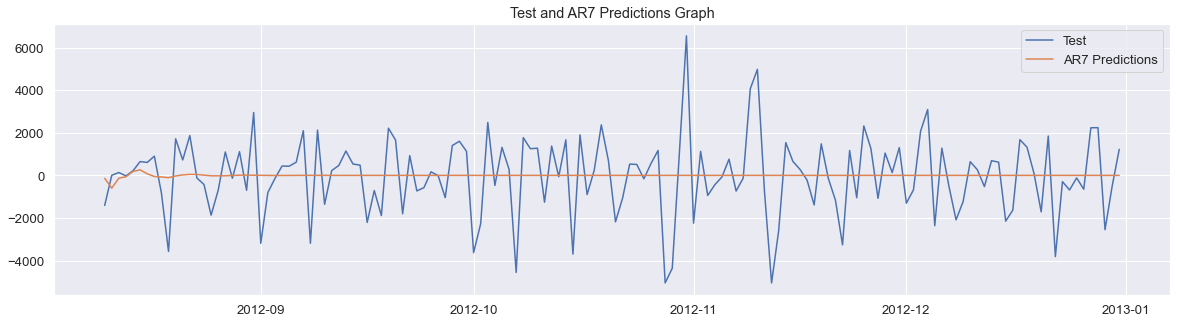

In [82]:
plt.figure(figsize=(20,5))
plt.plot(test.diff_12)
plt.plot(arpredictions)
plt.legend(["Test","AR7 Predictions"])
plt.title("Test and AR7 Predictions Graph")
plt.show()

### Moving Average Model

In [83]:
mavgmodel = ARMA(endog=train,order=(0,3))

In [84]:
mavgmodel_fit = mavgmodel.fit()

In [85]:
mavgmodel_fit.params

const           -0.013775
ma.L1.diff_12   -0.660973
ma.L2.diff_12   -0.252579
ma.L3.diff_12   -0.086389
dtype: float64

In [86]:
mavgmodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                diff_12   No. Observations:                  574
Model:                     ARMA(0, 3)   Log Likelihood               -4870.123
Method:                       css-mle   S.D. of innovations           1165.140
Date:                Fri, 09 Oct 2020   AIC                           9750.247
Time:                        10:07:34   BIC                           9772.010
Sample:                    01-14-2011   HQIC                          9758.736
                         - 08-09-2012                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0138      0.416     -0.033      0.974      -0.830       0.802
ma.L1.diff_12    -0.6610      0.042    -15.786      0.000      -0.743      -0.579
ma.L2.diff_12    -0.2526      0.052     -4.896      0.000      -0.354      -0.151
ma.L3.diff_12    -0.0864      0.041     -2.098      0.036      -0.167      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -1.9619           -2.7796j            3.4022           -0.3478
MA.3           -1.9619           +2.7796j            3.4022            0.3478
-----------------------------------------------------------------------------
"""

In [87]:
mavg_predictions = mavgmodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [88]:
mavg_predictions

2012-08-10   -349.705864
2012-08-11   -108.176463
2012-08-12    -27.082724
2012-08-13     -0.013775
2012-08-14     -0.013775
                 ...    
2012-12-27     -0.013775
2012-12-28     -0.013775
2012-12-29     -0.013775
2012-12-30     -0.013775
2012-12-31     -0.013775
Freq: D, Length: 144, dtype: float64

In [89]:
print(test)

            diff_12
dteday             
2012-08-10  -1412.0
2012-08-11      5.0
2012-08-12    134.0
2012-08-13    -25.0
2012-08-14    220.0
...             ...
2012-12-27   2237.0
2012-12-28   2242.0
2012-12-29  -2553.0
2012-12-30   -517.0
2012-12-31   1223.0

[144 rows x 1 columns]


In [90]:
mse = mean_squared_error(test, mavg_predictions)
mse

3344484.083369909

In [91]:
rmse = np.sqrt(mse)
rmse

1828.7930673998928

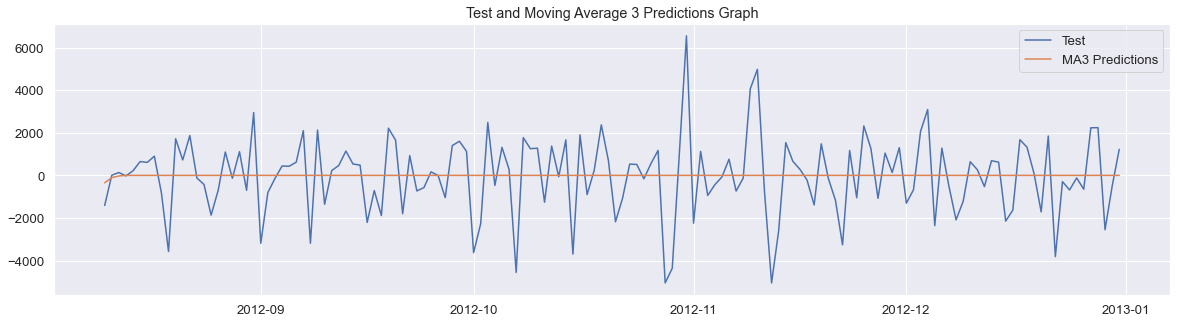

In [92]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(mavg_predictions)
plt.legend(["Test","MA3 Predictions"])
plt.title("Test and Moving Average 3 Predictions Graph")
plt.show()

### ARMA Model

In [93]:
armamodel = ARMA(train,order=(1,1))

In [94]:
armamodel_fit = armamodel.fit()

In [95]:
armamodel_fit.params

const           -0.013151
ar.L1.diff_12    0.338734
ma.L1.diff_12   -0.999965
dtype: float64

In [96]:
armamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                diff_12   No. Observations:                  574
Model:                     ARMA(1, 1)   Log Likelihood               -4869.737
Method:                       css-mle   S.D. of innovations           1164.467
Date:                Fri, 09 Oct 2020   AIC                           9747.473
Time:                        10:07:56   BIC                           9764.884
Sample:                    01-14-2011   HQIC                          9754.264
                         - 08-09-2012                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0132      0.441     -0.030      0.976      -0.878       0.852
ar.L1.diff_12     0.3387      0.039      8.612      0.000       0.262       0.416
ma.L1.diff_12    -1.0000      0.007   -140.618      0.000      -1.014      -0.986
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9522           +0.0000j            2.9522            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [97]:
armapredictions = armamodel_fit.predict(start=len(train),end=len(train)+len(test)-1)

In [98]:
armapredictions

2012-08-10   -320.199844
2012-08-11   -108.471295
2012-08-12    -36.751620
2012-08-13    -12.457723
2012-08-14     -4.228552
                 ...    
2012-12-27     -0.013151
2012-12-28     -0.013151
2012-12-29     -0.013151
2012-12-30     -0.013151
2012-12-31     -0.013151
Freq: D, Length: 144, dtype: float64

In [99]:
print(test)

            diff_12
dteday             
2012-08-10  -1412.0
2012-08-11      5.0
2012-08-12    134.0
2012-08-13    -25.0
2012-08-14    220.0
...             ...
2012-12-27   2237.0
2012-12-28   2242.0
2012-12-29  -2553.0
2012-12-30   -517.0
2012-12-31   1223.0

[144 rows x 1 columns]


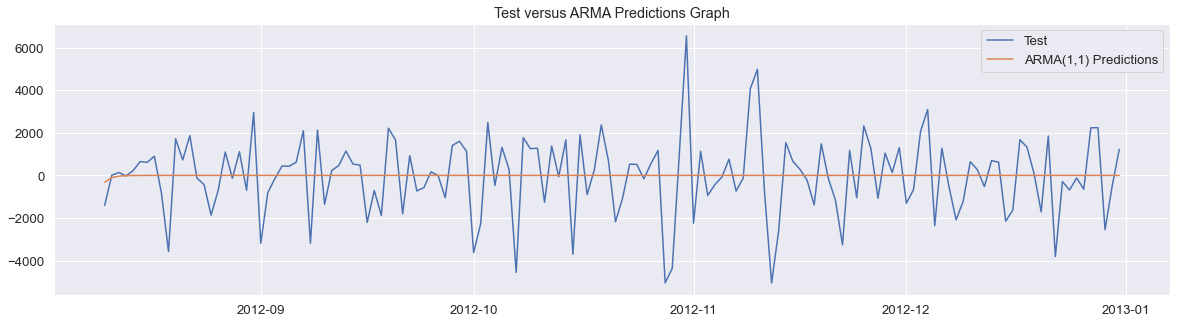

In [100]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(armapredictions)
plt.legend(["Test","ARMA(1,1) Predictions"])
plt.title("Test versus ARMA Predictions Graph")
plt.show()

In [101]:
mse = mean_squared_error(test, armapredictions)
mse

3344975.6354301185

In [102]:
rmse = np.sqrt(mse)
rmse

1828.9274549391287

In [103]:
armapredictions.mean()

-3.3756693758090397

### ARIMA Model

In [104]:
arimamodel = ARIMA(endog=train,order=(7,1,3))

In [105]:
arimamodel_fit = arimamodel.fit(trend='c')

In [106]:
arimamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.diff_12   No. Observations:                  573
Model:                 ARIMA(7, 1, 3)   Log Likelihood               -4857.353
Method:                       css-mle   S.D. of innovations           1144.999
Date:                Fri, 09 Oct 2020   AIC                           9738.707
Time:                        10:08:38   BIC                           9790.917
Sample:                    01-15-2011   HQIC                          9759.073
                         - 08-09-2012                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0035      0.101     -0.035      0.972      -0.202       0.195
ar.L1.D.diff_12    -1.4834      0.040    -37.061      0.000      -1.562      -1.405
ar.L2.D.diff_12    -1.8713      0.069    -27.118      0.000      -2.007      -1.736
ar.L3.D.diff_12    -1.3110      0.097    -13.459      0.000      -1.502      -1.120
ar.L4.D.diff_12    -1.1185      0.102    -11.008      0.000      -1.318      -0.919
ar.L5.D.diff_12    -0.9073      0.097     -9.320      0.000      -1.098      -0.717
ar.L6.D.diff_12    -0.6211      0.069     -9.001      0.000      -0.756      -0.486
ar.L7.D.diff_12    -0.2972      0.040     -7.459      0.000      -0.375      -0.219
ma.L1.D.diff_12    -0.0031      0.008     -0.403      0.687      -0.018       0.012
ma.L2.D.diff_12     0.0030      0.008      0.391      0.696      -0.012       0.018
ma.L3.D.diff_12    -0.9996      0.009   -113.239      0.000      -1.017      -0.982
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7090           -1.0109j            1.2347           -0.1527
AR.2            0.7090           +1.0109j            1.2347            0.1527
AR.3           -1.3902           -0.0000j            1.3902           -0.5000
AR.4           -0.3850           -1.0710j            1.1381           -0.3049
AR.5           -0.3850           +1.0710j            1.1381            0.3049
AR.6           -0.6740           -0.8784j            1.1071           -0.3542
AR.7           -0.6740           +0.8784j            1.1071            0.3542
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.4985           -0.8670j            1.0001           -0.3331
MA.3           -0.4985           +0.8670j            1.0001            0.3331
-----------------------------------------------------------------------------
"""

In [107]:
arimapredictions = arimamodel_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels').rename("ARIMA Predictions")

In [108]:
arimapredictions

2012-08-10   -241.569471
2012-08-11   -405.478828
2012-08-12   -601.515172
2012-08-13    526.475364
2012-08-14    558.337041
                 ...    
2012-12-27     -1.866362
2012-12-28     -1.869865
2012-12-29     -1.873779
2012-12-30     -1.876911
2012-12-31     -1.880579
Freq: D, Name: ARIMA Predictions, Length: 144, dtype: float64

In [109]:
print(test)

            diff_12
dteday             
2012-08-10  -1412.0
2012-08-11      5.0
2012-08-12    134.0
2012-08-13    -25.0
2012-08-14    220.0
...             ...
2012-12-27   2237.0
2012-12-28   2242.0
2012-12-29  -2553.0
2012-12-30   -517.0
2012-12-31   1223.0

[144 rows x 1 columns]


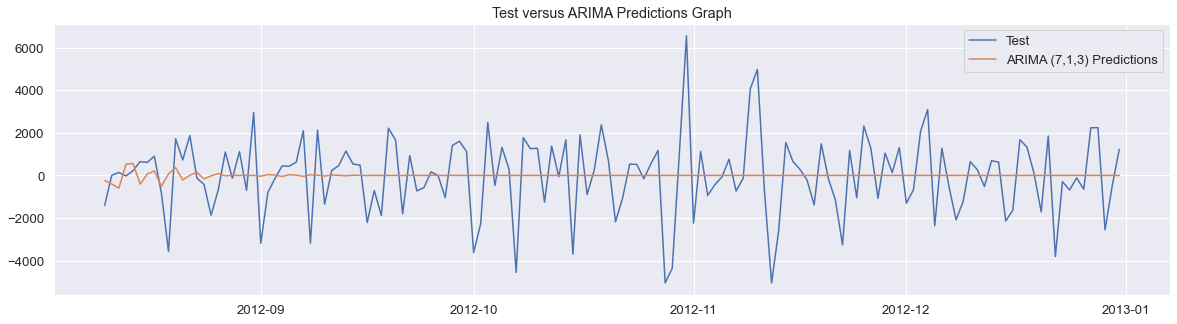

In [110]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(arimapredictions)
plt.legend(["Test","ARIMA (7,1,3) Predictions"])
plt.title("Test versus ARIMA Predictions Graph")
plt.show()

In [111]:
mse = mean_squared_error(test,arimapredictions)
mse

3350302.518578826

In [112]:
rmse = np.sqrt(mse)
rmse

1830.3831616846855

### SARIMA Model

In [113]:
sarimamodel = SARIMAX(endog=train, order=(7,1,3), seasonal_order=(3,1,1,12))

In [114]:
sarimamodel_fit = sarimamodel.fit()

In [115]:
sarimamodel_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              diff_12   No. Observations:                  574
Model:             SARIMAX(7, 1, 3)x(3, 1, [1], 12)   Log Likelihood               -4916.230
Date:                              Fri, 09 Oct 2020   AIC                           9862.460
Time:                                      10:09:50   BIC                           9927.406
Sample:                                  01-14-2011   HQIC                          9887.817
                                       - 08-09-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2678      0.168      1.592      0.111      -0.062       0.597
ar.L2         -1.2979      0.180     -7.191      0.000      -1.652      -0.944
ar.L3         -0.5586      0.237     -2.353      0.019      -1.024      -0.093
ar.L4         -0.6612      0.244     -2.708      0.007      -1.140      -0.183
ar.L5         -0.6374      0.222     -2.872      0.004      -1.072      -0.202
ar.L6         -0.1567      0.172     -0.913      0.361      -0.493       0.180
ar.L7         -0.3172      0.161     -1.974      0.048      -0.632      -0.002
ma.L1         -1.7048      0.096    -17.710      0.000      -1.894      -1.516
ma.L2          1.6730      0.111     15.083      0.000       1.456       1.890
ma.L3         -0.9470      0.092    -10.288      0.000      -1.127      -0.767
ar.S.L12      -0.7466      0.142     -5.248      0.000      -1.025      -0.468
ar.S.L24      -0.4940      0.202     -2.445      0.014      -0.890      -0.098
ar.S.L36      -0.2749      0.158     -1.742      0.082      -0.584       0.034
ma.S.L12      -0.8110      0.161     -5.028      0.000      -1.127      -0.495
sigma2       4.63e+06   2.33e-08   1.98e+14      0.000    4.63e+06    4.63e+06
===================================================================================
Ljung-Box (Q):                      147.11   Jarque-Bera (JB):                64.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.09e+30. Standard errors may be unstable.
"""

In [116]:
sarimapredictions = sarimamodel_fit.predict(start=len(train), end=len(train) + len(test) - 1).rename("SARIMA Predictions")

In [117]:
sarimapredictions

2012-08-10    -478.259022
2012-08-11   -1265.228489
2012-08-12     108.182953
2012-08-13     157.283035
2012-08-14     641.588689
                 ...     
2012-12-27     -36.767767
2012-12-28     301.018555
2012-12-29      96.213446
2012-12-30       8.465532
2012-12-31    -159.523812
Freq: D, Name: SARIMA Predictions, Length: 144, dtype: float64

In [118]:
print(test)

            diff_12
dteday             
2012-08-10  -1412.0
2012-08-11      5.0
2012-08-12    134.0
2012-08-13    -25.0
2012-08-14    220.0
...             ...
2012-12-27   2237.0
2012-12-28   2242.0
2012-12-29  -2553.0
2012-12-30   -517.0
2012-12-31   1223.0

[144 rows x 1 columns]


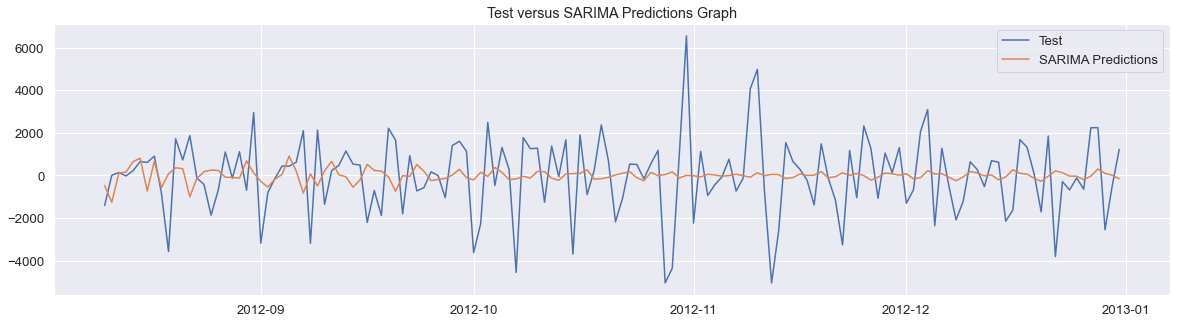

In [119]:
plt.figure(figsize=(20,5))
plt.plot(test)
plt.plot(sarimapredictions)
plt.legend(["Test","SARIMA Predictions"])
plt.title("Test versus SARIMA Predictions Graph")
plt.show()

In [120]:
mse = mean_squared_error(test,sarimapredictions)
mse

3520848.0953618493

In [121]:
rmse = np.sqrt(mse)
rmse

1876.392308490378

### Examine residuals

In [122]:
predictions = pd.DataFrame(sarimapredictions, index=test.index)

In [123]:
predictions

,SARIMA Predictions
dteday,
2012-08-10,-478.259022
2012-08-11,-1265.228489
2012-08-12,108.182953
2012-08-13,157.283035
2012-08-14,641.588689
...,...
2012-12-27,-36.767767
2012-12-28,301.018555
2012-12-29,96.213446


In [124]:
tests = pd.DataFrame(test, index=test.index)

In [125]:
tests

,diff_12
dteday,
2012-08-10,-1412.0
2012-08-11,5.0
2012-08-12,134.0
2012-08-13,-25.0
2012-08-14,220.0
...,...
2012-12-27,2237.0
2012-12-28,2242.0
2012-12-29,-2553.0


In [126]:
finaldf = pd.concat([tests,predictions],axis=1)

In [127]:
finaldf

,diff_12,SARIMA Predictions
dteday,,
2012-08-10,-1412.0,-478.259022
2012-08-11,5.0,-1265.228489
2012-08-12,134.0,108.182953
2012-08-13,-25.0,157.283035
2012-08-14,220.0,641.588689
...,...,...
2012-12-27,2237.0,-36.767767
2012-12-28,2242.0,301.018555
2012-12-29,-2553.0,96.213446


In [128]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2012-08-10 to 2012-12-31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   diff_12             144 non-null    float64
 1   SARIMA Predictions  144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


In [129]:
finaldf["residuals"] = finaldf["diff_12"] - finaldf["SARIMA Predictions"]

In [130]:
finaldf

,diff_12,SARIMA Predictions,residuals
dteday,,,
2012-08-10,-1412.0,-478.259022,-933.740978
2012-08-11,5.0,-1265.228489,1270.228489
2012-08-12,134.0,108.182953,25.817047
2012-08-13,-25.0,157.283035,-182.283035
2012-08-14,220.0,641.588689,-421.588689
...,...,...,...
2012-12-27,2237.0,-36.767767,2273.767767
2012-12-28,2242.0,301.018555,1940.981445
2012-12-29,-2553.0,96.213446,-2649.213446


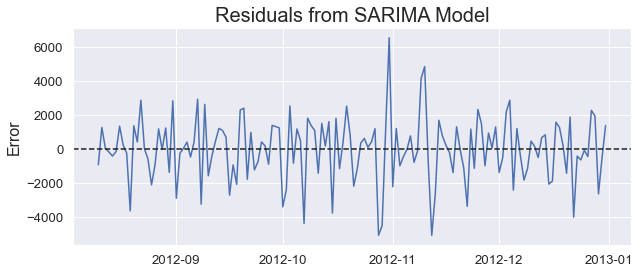

In [132]:
plt.figure(figsize=(10,4))
plt.plot(finaldf.residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

### Auto-ARIMA

In [133]:
stepwise_model = auto_arima(y=df.diff_12,exogenous=None,m=12,max_order=None,
                           max_p=7,max_q=7, max_d=2, max_P=4, max_Q=4, max_D=2,
                           maxiter=50, alpha=0.05, n_jobs=-1,trend=None, information_criterion='aic',
                           out_of_sample_size=int(len(df)*0.2),seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12557.102, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12322.734, Time=1.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12555.107, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12523.277, Time=0.22 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=12234.277, Time=6.50 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=12180.199, Time=19.74 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=12160.400, Time=38.81 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=12131.806, Time=31.13 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=12128.790, Time=16.79 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(1,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=18.80 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.62 sec
 ARIMA(1,0,0)(4,0,2)[12] inter

In [134]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  718
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 12)   Log Likelihood               -6057.395
Date:                              Fri, 09 Oct 2020   AIC                          12128.790
Time:                                      10:16:17   BIC                          12160.825
Sample:                                           0   HQIC                         12141.159
                                              - 718                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     69.1217     20.771      3.328      0.001      28.412     109.831
ar.L1         -0.3097      0.031     -9.905      0.000      -0.371      -0.248
ar.S.L12      -0.2355      0.071     -3.321      0.001      -0.375      -0.097
ar.S.L24      -0.1949      0.060     -3.238      0.001      -0.313      -0.077
ar.S.L36      -0.1179      0.055     -2.142      0.032      -0.226      -0.010
ma.S.L12      -0.6916      0.065    -10.608      0.000      -0.819      -0.564
sigma2        1.2e+06   4.19e+04     28.662      0.000    1.12e+06    1.28e+06
===================================================================================
Ljung-Box (Q):                      134.44   Jarque-Bera (JB):               752.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
print(stepwise_model.aic())

12128.789684119542


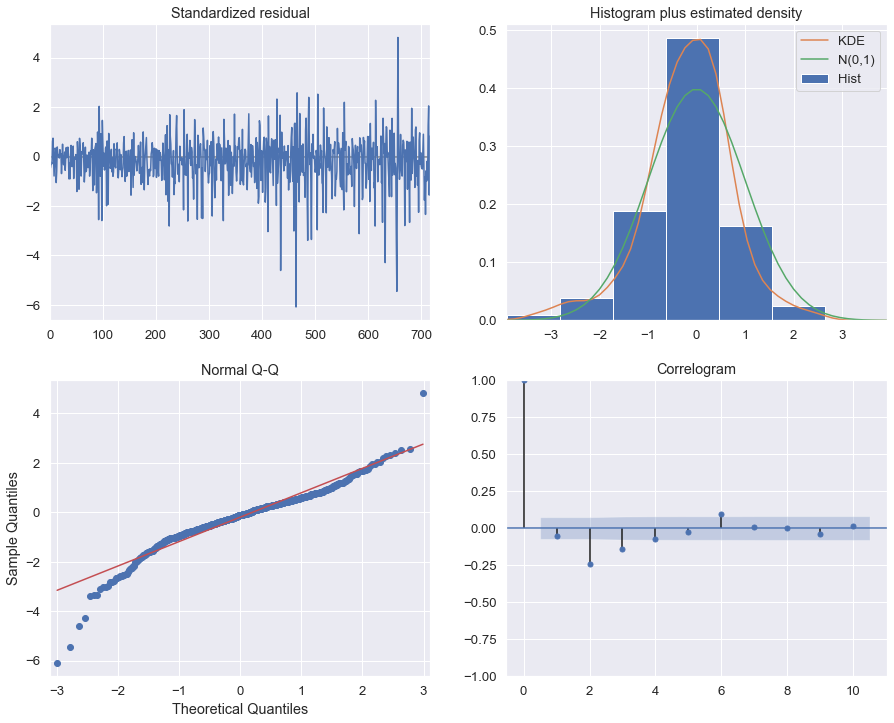

In [136]:
stepwise_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [137]:
autopredict = stepwise_model.predict(144)

In [138]:
autopredict

array([ 1632.10114203,   322.16269434,  2372.46322599,   -24.01390347,
         943.96717194,     3.96401818,   902.41661128, -1468.7787033 ,
       -1710.78790857,  2155.90994398,  -553.44337155,  -721.83772329,
         413.30277067,  -289.92514731,   177.86672062,    79.03346117,
          27.58320487,    -6.59195419,  -105.97183176,   216.09753636,
         211.34650471,  -155.08763606,   127.54159679,   -24.61799882,
        -160.65499961,  -159.70906296,    -1.5432511 ,    73.38417744,
         -56.91139994,    67.70288224,   -21.36791007,    24.36498938,
          72.05426464,   -29.82817982,   191.53678899,    55.05003962,
        -182.34376913,   108.90575361,  -261.22449165,    22.92184498,
         -50.48539921,    37.64706977,   -27.93246208,   178.08886236,
         196.31464134,  -164.15006267,    48.05906835,   129.70856074,
          78.30112537,    92.42871115,    93.63034102,    23.75884606,
          72.50398443,    31.49269456,    76.01154682,   -19.39329889,
      

In [139]:
autopredictdf = pd.DataFrame(autopredict, index=test.index, columns=["prediction"])

In [140]:
autopredictdf

,prediction
dteday,
2012-08-10,1632.101142
2012-08-11,322.162694
2012-08-12,2372.463226
2012-08-13,-24.013903
2012-08-14,943.967172
...,...
2012-12-27,34.575214
2012-12-28,34.738247
2012-12-29,33.267804


In [141]:
test

,diff_12
dteday,
2012-08-10,-1412.0
2012-08-11,5.0
2012-08-12,134.0
2012-08-13,-25.0
2012-08-14,220.0
...,...
2012-12-27,2237.0
2012-12-28,2242.0
2012-12-29,-2553.0


In [142]:
testdf = pd.DataFrame(test.values, index=test.index, columns=["test"])

In [143]:
testdf

,test
dteday,
2012-08-10,-1412.0
2012-08-11,5.0
2012-08-12,134.0
2012-08-13,-25.0
2012-08-14,220.0
...,...
2012-12-27,2237.0
2012-12-28,2242.0
2012-12-29,-2553.0


In [144]:
finalresult = pd.concat([testdf,autopredictdf],axis=1)

In [145]:
finalresult

,test,prediction
dteday,,
2012-08-10,-1412.0,1632.101142
2012-08-11,5.0,322.162694
2012-08-12,134.0,2372.463226
2012-08-13,-25.0,-24.013903
2012-08-14,220.0,943.967172
...,...,...
2012-12-27,2237.0,34.575214
2012-12-28,2242.0,34.738247
2012-12-29,-2553.0,33.267804


In [146]:
finalresult.to_csv("result.csv",index=True)

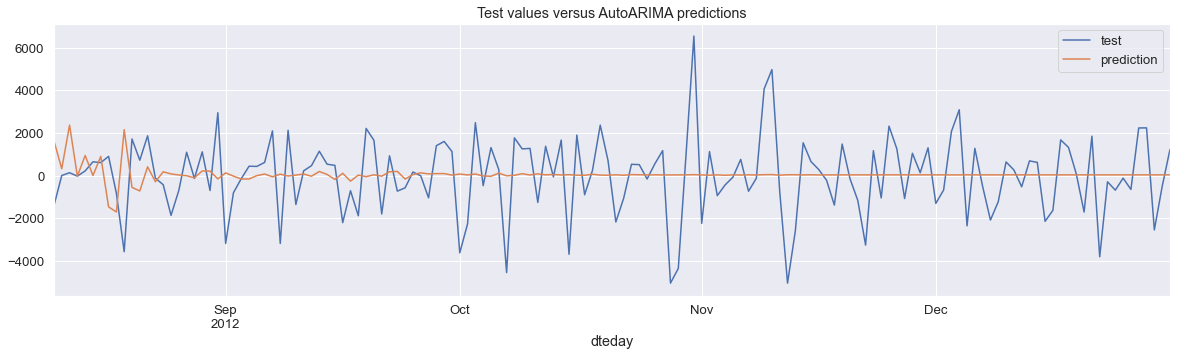

In [147]:
finalresult.test.plot(figsize=(20,5),legend=True)
finalresult.prediction.plot(legend=True)
plt.title("Test values versus AutoARIMA predictions")
plt.show()

### Zooming in date range

In [148]:
zoom = finalresult[(finalresult.index >= '2012-08-10') & (finalresult.index <= '2012-09-10')]

In [149]:
zoom

,test,prediction
dteday,,
2012-08-10,-1412.0,1632.101142
2012-08-11,5.0,322.162694
2012-08-12,134.0,2372.463226
2012-08-13,-25.0,-24.013903
2012-08-14,220.0,943.967172
2012-08-15,649.0,3.964018
2012-08-16,609.0,902.416611
2012-08-17,903.0,-1468.778703
2012-08-18,-832.0,-1710.787909


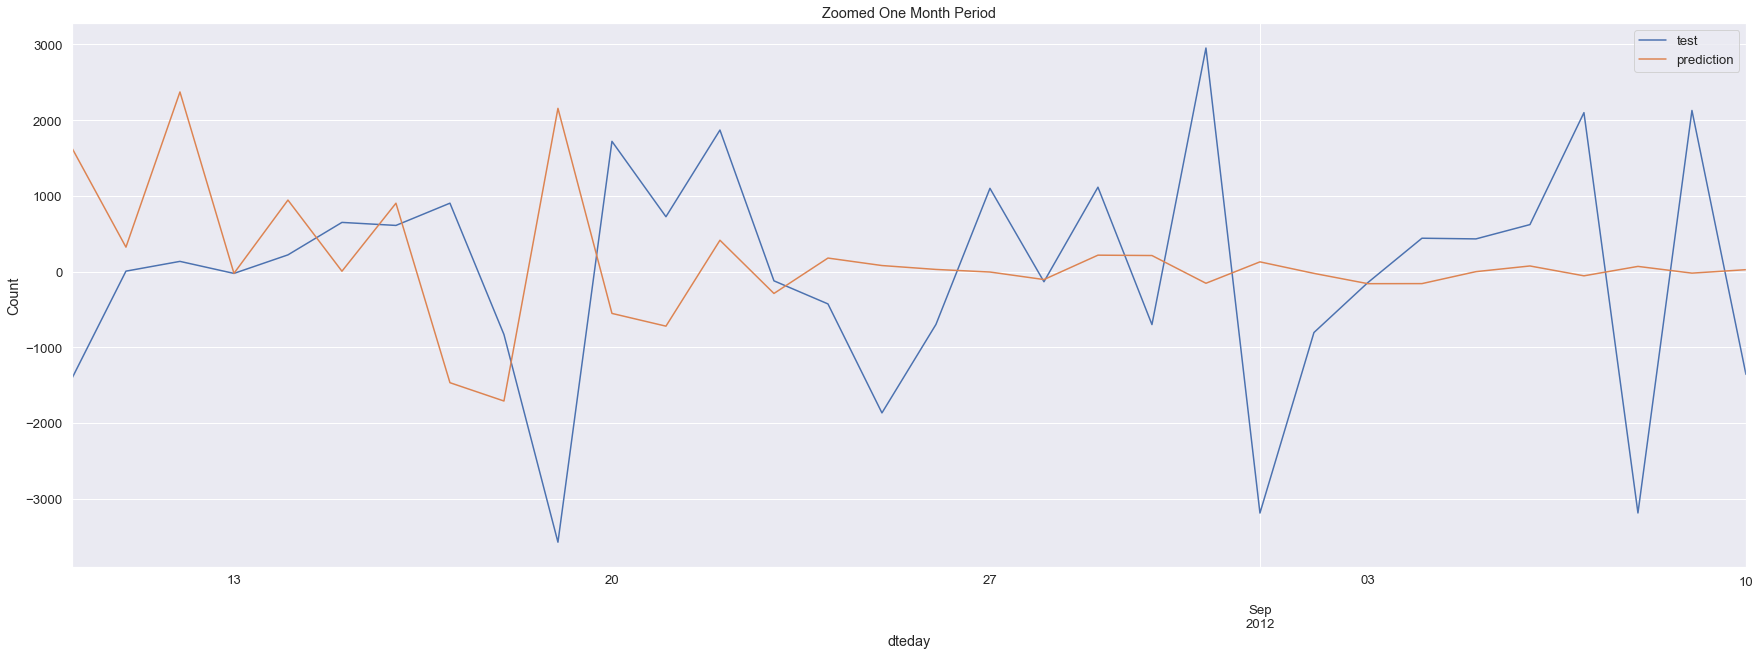

In [150]:
zoom.plot(figsize=(30,10), title="Zoomed One Month Period")
plt.ylabel("Count")
plt.show()

### Model Evaluation

In [151]:
test = finalresult.test
prediction = finalresult.prediction

In [152]:
mse = mean_squared_error(test,prediction)
mse

3645990.10097988

In [153]:
rmse = np.sqrt(mse)
rmse

1909.4475905297531

# Conclusion: We will follow auto-arima recommendation: SARIMAX(1, 0, 0)x(3, 0, [1], 12)